# Interactively validate a Convolutional Variational Autoencoder

The code in this nodebook is loading a pre-trained model and experiment with the encoder and decoder. 

In [1]:
import sys
sys.path.append("..")
# adding the Julian-8897-Conv-VAE-PyTorch into the path
from settings import Config
sys.path.append(Config().values["conv_vae"]["code_dir"])
# from encoding_conv_vae.conv_vae import latest_json_and_model

from sensorprocessing import sp_conv_vae
from sensorprocessing import sp_helper

from helper import ui_choose_task, ui_choose_demo
import os
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Oh, this hack was fixing something, but for me it is the other way around
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

Loading pointer config file: /home/lboloni/.config/BerryPicker/mainsettings.yaml
Loading machine-specific config file: /home/lboloni/Insync/lotzi.boloni@gmail.com/Google Drive/LotziStudy/Code/PackageTracking/BerryPicker/settings/settings-tredy2.yaml


In [2]:
# pick the latest
# conv_vae_jsonfile, resume_model_pthfile = latest_json_and_model()
run = "vae_00"
exp = Config().get_experiment("conv_vae", run)
model_subdir = Path(exp["data_dir"], exp["model_dir"], "models", exp["model_name"], exp["model_subdir"])
conv_vae_jsonfile = Path(model_subdir, "config.json")
resume_model_pthfile = Path(model_subdir, exp["model_checkpoint"])
print(conv_vae_jsonfile)
if conv_vae_jsonfile.exists():
    print("Exists!")
print(resume_model_pthfile)

Missing experiment system dependent config file /home/lboloni/Insync/lotzi.boloni@gmail.com/Google Drive/LotziStudy/Code/PackageTracking/BerryPicker/settings/experiment-config/Tredy2/conv_vae/vae_00_sysdep.yaml, that is ok, proceeding.
Configuration for experiment: conv_vae/vae_00 successfully loaded
/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-experiments/conv_vae/vae_00/models/models/VAE_Robot/1220_172927/config.json
Exists!
/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-experiments/conv_vae/vae_00/models/models/VAE_Robot/1220_172927/checkpoint-epoch100.pth


In [3]:

sp = sp_conv_vae.ConvVaeSensorProcessing(conv_vae_jsonfile, resume_model_pthfile)
print(sp.model)
print(sp.model.encoder)
print(f"latent_dim {sp.model.latent_dim}")
# print(model.hidden_dims)

/home/lboloni/Documents/Hackingwork/_Checkouts/BerryPicker/BerryPicker/src/encoding_conv_vae/../sensorprocessing/sp_conv_vae.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

## Pass one picture through the complete autoencoder

Pass one specific picture through the complete autoencoder. Compare the input and the output. This is basically trying out whether the VAE had captured the picture sufficiently.

This code also is intended as a sample of how to use the pre-trained model, how to feed it new data without the training code. 

In [5]:
# picture_name = '../../localdata/img/Rafael.jpg'
# picture_name = '../../localdata/img/indian-man.jpeg'
# picture_name = '../../localdata/img/00029_dev2.jpg'

# Choose a random image from the training data. 

directory = Path(Config().values["conv_vae"]["training_data_dir"], "Images")
print(directory)
files = list(directory.glob('*.jpg'))
picture_name = Path(directory, files[11])


/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-training-data/vae-training-data/Images


Check if the sensor processing object works

In [6]:
def visualize_VAE(sp, picture_name, axoriginal, axreconstr):
    """Visualize the performance of the reconstruction of a VAE sensorprocessing object. Show the original and the reconstruction in fields of a picture."""
    transform = sp_helper.get_transform_to_robot()
    input, image = sp_helper.load_picturefile_to_tensor(picture_name, transform)
    # Running the input on the output
    output, mu, logvar = sp.model(input)
    # Output: the visual reconstruction
    output_for_pic = output[0].cpu().permute(1, 2, 0).detach().numpy()
    # Showing the input and the reconstruction    
    axoriginal.imshow(image)
    axreconstr.imshow(output_for_pic)


Demo directory /home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos found with tasks [PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/boxmove'), PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/marker_solo'), PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/proprioception-cluttered'), PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/proprioception-uncluttered'), PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/tomatopicking'), PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/touch-brown'), PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/touch-spoon'), PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/touch-white'), PosixPath('/home/lboloni/Documents/Hackingwork/__Temporary/BerryPicker-demos/demos/to

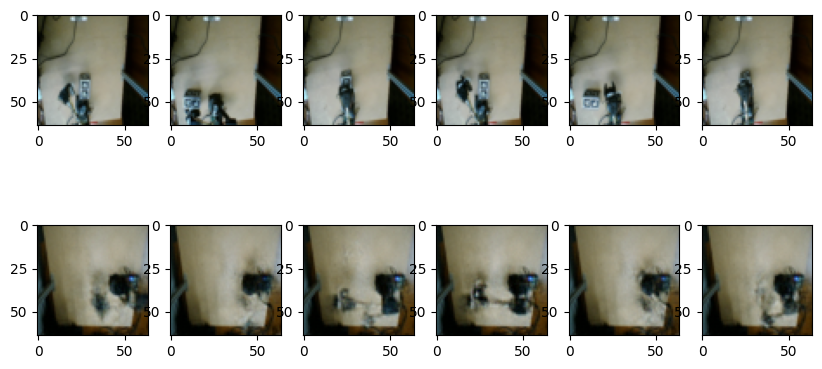

In [7]:
# Implement me: choose a random set of images from a task

_, task_dir = ui_choose_task(offer_task_creation=True)
print(task_dir)
demo_dir = ui_choose_demo(task_dir)
# FIXME: need to choose the demonstration
jpg_files = list(demo_dir.glob("*.jpg"))
n = 6
randomjpg = random.sample(jpg_files, n)
fig, axs = plt.subplots(2, n, figsize=(10, 5))
for i in range(n):
    visualize_VAE(sp, randomjpg[i], axs[0,i], axs[1,i])

In [9]:

# Try to do a decoding from the same mu
z2 = sp.model.reparameterize(mu, logvar)

for i in range(Config().values["robot"]["latent_encoding_size"]):
    z2[0][i] = z2[0][i] + 0.1

#z2[0][1] = 2.0
#z2[0][3] = 2.0
output2 = sp.model.decode(z2)
output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()

# initial and new
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(output_for_pic)
axs[1].imshow(output_for_pic2)


NameError: name 'mu' is not defined

# Generating random samples from the model

In [ ]:
import random

# z2 = model.reparameterize(mu, logvar)
# initial and new
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for x in range(0, 5):
    for y in range(0, 5):
            z2 = sp.model.reparameterize(mu, logvar)
            for i in range(Config().values["robot"]["latent_encoding_size"]):
                z2[0][i] += random.uniform(-0.5, 0.5)
            output2 = sp.model.decode(z2)
            output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()
            axs[x][y].imshow(output_for_pic2)
#axs[0].imshow(output_for_pic)
#axs[1].imshow(output_for_pic2)